Install TenSEAL

In [ ]:
pip install tenseal==0.3.0a1

     |████████████████████████████████| 5.3 MB 5.5 MB/s 


In [ ]:
pip install sklearn

In [ ]:
import pandas as pd
import numpy as np
import random
from time import time
# from sklearn.datasets.samples_generator import make_blobs
import tenseal as ts
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
random.seed(4)

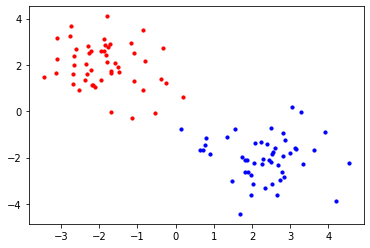

In [ ]:
def gen_random_data():
  centers = [(-2, 2), (2, -2)]
  cluster_std = [1, 1]
  return make_blobs(n_samples=100, cluster_std=cluster_std, centers=centers, n_features=2, random_state=1)

X, y = gen_random_data()

plt.scatter(X[y == 0, 0], X[y == 0, 1], color="red", s=10, label="Cluster1")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="blue", s=10, label="Cluster2")

In [ ]:
def split_train_test(x, y, test_ratio=0.3):
    idxs = [i for i in range(len(x))]
    random.shuffle(idxs)
    # delimiter between test and train data
    delim = int(len(x) * test_ratio)
    test_idxs, train_idxs = idxs[:delim], idxs[delim:]
    return x[train_idxs], y[train_idxs], x[test_idxs], y[test_idxs]

In [ ]:
X_train, y_train, X_test, y_test = split_train_test(X,y)

NameError: ignored

[[ 2.29568621 -2.22233134]] [0.18997685]


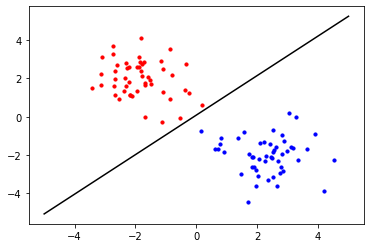

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - (clf.intercept_[0]) / w[1]
print(clf.coef_, clf.intercept_)
plt.plot(xx, yy, 'k-')
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="red", s=10, label="Cluster1")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="blue", s=10, label="Cluster2")
plt.show()

**Encrypted LR Class**

#### Parameters Update for LR

For updating the parameter, the usual rule is as follows, where $x^{(i)}$ is the i'th input data

$$\theta_j = \theta_j - \alpha \; [ \frac{1}{m} \sum_{i=1}^m (\hat{y}^{(i)} - y^{(i)}) x^{(i)} + \frac{\lambda}{m} \theta_j]$$

However, due to homomorphic encryption constraint, we preferred to set $\frac{\lambda}{m} = 0.05$ which gets us to the following update rule

$$\theta_j = \theta_j - \alpha \; [ \frac{1}{m} \sum_{i=1}^m (\hat{y}^{(i)} - y^{(i)}) x^{(i)} + 0.05 \theta_j]$$

#### Sigmoid Approximation

Since we can't simply compute sigmoid on encrypted data, we need to approximate it using a low degree polynomial, the lowest degree the better, as we aim to perform as little multiplications as possible, to be able to use smaller parameters and thus optimize computation. This tutorial uses a degree 3 polynomial from https://eprint.iacr.org/2018/462.pdf which approximates the sigmoid function in the range $[-5,5]$

$$\sigma(x) = 0.5 + 0.197 x - 0.004 x^3$$

In [ ]:
# parameters
poly_mod_degree = 16384
coeff_mod_bit_sizes = [37, 28, 28, 28, 28, 28, 28, 28, 37]
# create TenSEALContext
ctx_training = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, coeff_mod_bit_sizes=coeff_mod_bit_sizes)
# global_scale is used for encoding stage
ctx_training.global_scale = 2 ** 28
ctx_training.generate_galois_keys()

In [ ]:
def encrypt_train_data(X_train, y_train):
  enc_x_train = [ts.ckks_vector(ctx_training, X_i) for X_i in X_train]
  enc_y_train = [ts.ckks_vector(ctx_training, [y_i]) for y_i in y_train]
  return enc_x_train, enc_y_train


def heart_disease_data():
    data = pd.read_csv("./framingham.csv")
    # drop rows with missing values
    data = data.dropna()
    # drop some features
    data = data.drop(columns=["education", "currentSmoker", "BPMeds", "diabetes", "diaBP", "BMI"])
    # balance data
    grouped = data.groupby('TenYearCHD')
    data = grouped.apply(lambda x: x.sample(grouped.size().min(), random_state=73).reset_index(drop=True))
    # extract labels
    y = data["TenYearCHD"].values
    data = data.drop("TenYearCHD", 'columns')
    # standardize data
    data = (data - data.mean()) / data.std()
    return data.values, y


In [ ]:
X, y = heart_disease_data()
X_train, y_train, X_test, y_test = split_train_test(X, y)
t_start = time()
enc_X_train, enc_y_train = encrypt_train_data(X_train, y_train)
print(f"Encryption runtime is {time() - t_start}")

Encryption runtime is 57.80588912963867


In [ ]:
len(X)

1114

In [ ]:
def approximate_sigmoid(enc_x):
        # We use the polynomial approximation of degree 3
        # sigmoid(x) = 0.5 + 0.197 * x - 0.004 * x^3
        # from https://eprint.iacr.org/2018/462.pdf
        # which fits the function pretty well in the range [-5,5]
        return enc_x.polyval([0.5, 0.197, 0, -0.004])

def sigmoid(x):
        return 1 / (1 + np.exp(-x))

With a scale of around 20-bits, we need 6 coefficients modulus with the same bit-size as the scale, plus the last coeffcient, which needs more bits, we are already out of the 4096 polynomial modulus degree (which requires < 109 total bit count of the coefficients modulus, if we consider 128-bit security), so we will use 8192. This will allow us to batch up to 4096 values in a single ciphertext, but we are far away from this limitation, so we shouldn't even think about it.

In [ ]:
class EncryptedLR:
    def __init__(self, context, n_features, epoch, lr=0.01):
      self.context = context
      self.weight = np.zeros(n_features).tolist()
      self.bias = [0]
      # we accumulate gradients and counts the number of iterations
      self._delta_w = 0
      self._delta_b = 0
      self._count = 0
      self._lr = lr
      self._epoch = epoch
        
    def __forward(self, enc_x):
        # this need to do the shift
        enc_out = enc_x.dot(self.weight) + self.bias # self.weight has wrong size
        # this need to do the shift
        enc_out = approximate_sigmoid(enc_out)
        return enc_out
    
    def __backward(self, enc_x, enc_out, enc_y):
        out_minus_y = (enc_out - enc_y)
        a = enc_x * out_minus_y
        self._delta_w += a
        self._delta_b += out_minus_y
        self._count += 1
        
    def __update_parameters(self):
        # update weights
        # We use a small regularization term to keep the output
        # of the linear layer in the range of the sigmoid approximation
        self.weight -= self._lr * (self._delta_w * (1 / self._count))
        self.bias -= self._lr * (self._delta_b * (1 / self._count))
        # reset gradient accumulators and iterations count
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0

    def train(self, enc_x_train, enc_y_train, X_train, y_train, X_test, y_test):
        for epoch in range(self._epoch):
          print(f"---------------START epoch #{epoch + 1}---------------")
          self.__encrypt()
          t_start = time()
          for enc_x, enc_y in zip(enc_x_train, enc_y_train):
              enc_out = self.__forward(enc_x)
              self.__backward(enc_x, enc_out, enc_y)
          self.__update_parameters()
          self.__decrypt()
          t_end = time()
          acc = self.__get_test_accuracy(X_test, y_test)
          print(f"Accuracy on test set at epoch #{epoch + 1} is {acc}")
          print(f"Loss at epoch #{epoch + 1} is {self.__get_loss(X_train, y_train)}")
          print(f"Time at epoch #{epoch + 1} is {t_end - t_start}")
          print(f"---------------FINISH epoch #{epoch + 1}---------------")

    def __encrypt(self):
        self.weight = ts.ckks_vector(self.context, self.weight)
        self.bias = ts.ckks_vector(self.context, self.bias)
        
    def __decrypt(self):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()

    def __get_test_accuracy(self, X_test, y_test):
        print("weights", self.weight)
        print("bias", self.bias)
        clf_acc = LogisticRegression()
        clf_acc.classes_ = np.unique(y_test)
        clf_acc.coef_ = np.array([self.weight])
        clf_acc.intercept_ = np.array([self.bias])
        #w = clf_acc.coef_[0]
        #a = -w[0] / w[1]
        #xx = np.linspace(-5, 5)
        #yy = a * xx - (clf_acc.intercept_[0]) / w[1]

        #plt.plot(xx, yy, 'k-')
        #plt.scatter(X[y == 0, 0], X[y == 0, 1], color="red", s=10, label="Cluster1")
        #plt.scatter(X[y == 1, 0], X[y == 1, 1], color="blue", s=10, label="Cluster2")
        #plt.show()
        return clf_acc.score(X_test, y_test)
    
    def __get_loss(self, X_train, y_train):
      out = X_train.dot(np.array(self.weight)) + self.bias
      out = sigmoid(out)
      return (-y_train * np.log(out) - (1 - y_train) * np.log(1 - out)).mean()

    def get_enc_coef(self):
      return self.weight, self.bias
        
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)


In [ ]:
eelr = EncryptedLR(context=ctx_training, n_features=9, epoch=100, lr=0.01)
eelr.train(enc_X_train, enc_y_train, X_train, y_train, X_test, y_test)

---------------START epoch #1---------------
weights [0.0007020939674935655, 0.0015579901808392593, 0.0003347598015338586, 0.00044716560179067867, 0.001224206290161402, 0.0007896788532518462, 0.0014608845780728697, 0.00028629526225894535, 0.000688043665617393]
bias [-3.167596277335486e-05]
Accuracy on test set at epoch #1 is 0.6826347305389222
Loss at epoch #1 is 0.6923552315078962
Time at epoch #1 is 383.89735102653503
---------------FINISH epoch #1---------------
---------------START epoch #2---------------
weights [0.0013867007938673788, 0.0031070983597819672, 0.0006729139956739927, 0.0008829757634299943, 0.0024575524694765314, 0.0015448755637151512, 0.0028721955460317174, 0.0005589161469855741, 0.0013697448796040168]
bias [-8.65935417125739e-05]
Accuracy on test set at epoch #2 is 0.6766467065868264
Loss at epoch #2 is 0.6915793200536383
Time at epoch #2 is 382.28174471855164
---------------FINISH epoch #2---------------
---------------START epoch #3---------------
weights [0.00207

KeyboardInterrupt: ignored

In [ ]:
from sklearn.linear_model import LogisticRegression

class LRGD:
    def __init__(self, n_features, epoch, lr=0.01):
      self.weight = np.zeros(n_features)
      self.bias = np.zeros(1)
      # we accumulate gradients and counts the number of iterations
      self._delta_w = 0
      self._delta_b = 0
      self._count = 0
      self._lr = lr
      self._epoch = epoch
        
    def __forward(self, x):
        # this need to do the shift
        out = x.dot(self.weight) + self.bias
        # this need to do the shift
        out = self.approximate_sigmoid(out)
        return out
    
    def __backward(self, x, out, y):
        out_minus_y = (out - y)
        a = x * out_minus_y
        self._delta_w += a
        self._delta_b += out_minus_y
        self._count += 1
        
    def __update_parameters(self):
        # update weights
        # We use a small regularization term to keep the output
        # of the linear layer in the range of the sigmoid approximation
        self.weight -= self._lr * (self._delta_w * (1 / self._count))
        self.bias -= self._lr * (self._delta_b * (1 / self._count))
        # reset gradient accumulators and iterations count
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0

    def train(self, X_train, y_train, X_test, y_test):
        for epoch in range(self._epoch):
          print(f"---------------START epoch #{epoch + 1}---------------")
          t_start = time()
          for x, y in zip(X_train, y_train):
              out = self.__forward(x)
              self.__backward(x, out, y)
          self.__update_parameters()
          t_end = time()
          acc = self.__get_test_accuracy(X_test, y_test)
          print(f"Accuracy on test set at epoch #{epoch + 1} is {acc}")
          print(f"Loss at epoch #{epoch + 1} is {self.__get_loss(X_train, y_train)}")
          print(f"Time at epoch #{epoch + 1} is {t_end - t_start}")
          print(f"---------------FINISH epoch #{epoch + 1}---------------")

    def __get_test_accuracy(self, X_test, y_test):
        print("weights", self.weight)
        print("bias", self.bias)
        clf_acc = LogisticRegression()
        clf_acc.classes_ = np.unique(y_test)
        clf_acc.coef_ = np.array([self.weight])
        clf_acc.intercept_ = np.array([self.bias])
        #w = clf_acc.coef_[0]
        #a = -w[0] / w[1]
        #xx = np.linspace(-5, 5)
        #yy = a * xx - (clf_acc.intercept_[0]) / w[1]

        #plt.plot(xx, yy, 'k-')
        #plt.scatter(X[y == 0, 0], X[y == 0, 1], color="red", s=10, label="Cluster1")
        #plt.scatter(X[y == 1, 0], X[y == 1, 1], color="blue", s=10, label="Cluster2")
        #plt.show()
        return clf_acc.score(X_test, y_test)
    
    def get_enc_coef(self):
      return self.weight, self.bias

    def __get_loss(self, X_train, y_train):
      out = X_train.dot(np.array(self.weight)) + self.bias
      out = sigmoid(out)
      return (-y_train * np.log(out) - (1 - y_train) * np.log(1 - out)).mean()

    def approximate_sigmoid(self, x):
        # We use the polynomial approximation of degree 3
        # sigmoid(x) = 0.5 + 0.197 * x - 0.004 * x^3
        # from https://eprint.iacr.org/2018/462.pdf
        # which fits the function pretty well in the range [-5,5]
        return 0.5 + 0.197 * x - 0.004 * x * x * x
        
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)


In [ ]:
lrgd = LRGD(n_features=2, epoch=100, lr=0.01)
lrgd.train(X_train, y_train, X_test, y_test)

---------------START epoch #1---------------
weights [ 0.00981938 -0.00997551]
bias [0.00015714]
Accuracy on test set at epoch #1 is 1.0
Loss at epoch #1 is 0.6737700499764444
Time at epoch #1 is 0.028554677963256836
---------------FINISH epoch #1---------------
---------------START epoch #2---------------
weights [ 0.01946572 -0.01977627]
bias [0.00031113]
Accuracy on test set at epoch #2 is 1.0
Loss at epoch #2 is 0.6551585459581651
Time at epoch #2 is 0.03011608123779297
---------------FINISH epoch #2---------------
---------------START epoch #3---------------
weights [ 0.02894211 -0.02940541]
bias [0.00046202]
Accuracy on test set at epoch #3 is 1.0
Loss at epoch #3 is 0.6372835539081377
Time at epoch #3 is 0.02848029136657715
---------------FINISH epoch #3---------------
---------------START epoch #4---------------
weights [ 0.03825163 -0.03886604]
bias [0.00060987]
Accuracy on test set at epoch #4 is 1.0
Loss at epoch #4 is 0.6201165092089621
Time at epoch #4 is 0.023267984390258

In [ ]:
import numpy as np


def nparraytocsv(nparray, name):
        name = name + ".csv"
        np.savetxt(name, nparray, delimiter=',', fmt='%f')

def csvtonparray(name):
        tmp = np.genfromtxt(name, delimiter=',')
        if (np.isnan(tmp[0,0])):
          X = tmp[1:,1:-1]
          y = tmp[1:,-1]
        else:
          X = tmp[:,0:-1]
          y = tmp[:,-1]
        return X, y

def concatnparrays(nparray1, nparray2):
        return np.concatenate((nparray1, nparray2[:,None]),axis=1)


# nparraytocsv(concatnparrays(X,y), "dataset")

X, y = csvtonparray("LogReg_sample_dataset.csv")
# X, y = heart_disease_data()
X_train, y_train, X_test, y_test = split_train_test(X, y)


In [ ]:
import psutil
    
psutil.virtual_memory().used

632213504

In [ ]:
enc_X, enc_y = encrypt_train_data(X, y)

In [ ]:
def csvtonparray_random_sampling(name, sample_number):
        tmp = np.genfromtxt(name, delimiter=',')
        if (np.isnan(tmp[0,0])):
          tmp = tmp[1:, 1:]
          np.random.shuffle(tmp)
          #print(tmp[0])
          #print('tmp size: ' , tmp.shape())
          #ids = np.random.randint(50000, size = sample_number)
          #tmp = tmp[np.random.choice(tmp.shape[0], 30000, replace=False), :]
          #tmp = tmp[ids, :]
          #print('tmp size after: ' , tmp[0].shape())
          X = tmp[:sample_number,0:-1]
          y = tmp[:sample_number,-1]
        else:
          np.random.shuffle(tmp)
          #print(tmp[0])
          #print('tmp size: ' , tmp.shape())
          #ids = np.random.randint(50000, size = sample_number)
          #tmp = tmp[np.random.choice(tmp.shape[0], 30000, replace=False), :]
          #tmp = tmp[ids, :]
          #print('tmp size after: ' , tmp[0].shape())
          X = tmp[:sample_number,0:-1]
          y = tmp[:sample_number,-1]
        return X, y

In [ ]:
HRF_x, HRF_y = csvtonparray_random_sampling("HRF_samples_big.csv", 1000)
print(HRF_x[0])
print(HRF_y[0])
print(HRF_x.shape)
print(HRF_y.shape)

[ 0.26270492 -3.23084439  2.22509517  0.03978098 -3.23084439]
0.0
(10000, 5)
(10000,)


In [ ]:
HRF_x, HRF_y = csvtonparray("HRF_samples_big.csv")
print(HRF_x[0])
print(HRF_y[0])
print(HRF_x.shape)
print(HRF_y.shape)

NameError: ignored

In [ ]:
#code cell to upgrade the Colab to 25gb ram
[1]*10**10
#a = []
#while(1):
#    a.append('1')

In [ ]:
HRF_x, HRF_y = csvtonparray_random_sampling("HRF_samples_big.csv", 2000)
HRF_x_train, HRF_y_train, HRF_x_test, HRF_y_test = split_train_test(HRF_x, HRF_y)

enc_HRF_x_train, enc_HRF_y_train = encrypt_train_data(HRF_x_train, HRF_y_train)

In [ ]:
HRF_x, HRF_y = csvtonparray("HRF_samples_big.csv")
HRF_x_train, HRF_y_train, HRF_x_test, HRF_y_test = split_train_test(HRF_x, HRF_y)

enc_HRF_x_train, enc_HRF_y_train = encrypt_train_data(HRF_x_train, HRF_y_train)

In [ ]:
eelr = EncryptedLR(context=ctx_training, n_features=len(HRF_x_train[0,:]), epoch=100, lr=1)
eelr.train(enc_HRF_x_train, enc_HRF_y_train, HRF_x_train, HRF_y_train, HRF_x_test, HRF_y_test)

---------------START epoch #1---------------
weights [0.5096156753124839, -0.20609416918324758, 1.494099112684812, 2.1703677271992303, -0.22296554616006234]
bias [0.008313191442107076]
Accuracy on test set at epoch #1 is 0.5233333333333333
Loss at epoch #1 is nan
Time at epoch #1 is 591.2497644424438
---------------FINISH epoch #1---------------
---------------START epoch #2---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [239.6487993061462, -189.92292012434706, 652.1354251904318, 776.1235740730324, -189.9565537994645]
bias [80.8565706206167]
Accuracy on test set at epoch #2 is 0.5216666666666666
Loss at epoch #2 is nan
Time at epoch #2 is 588.6539278030396
---------------FINISH epoch #2---------------
---------------START epoch #3---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [12249.212959761555, 8410.482679904562, 29838.35608221865, -4665.728947361352, 6825.23435065629]
bias [5734149544.462393]
Accuracy on test set at epoch #3 is 0.5183333333333333
Loss at epoch #3 is nan
Time at epoch #3 is 588.9826507568359
---------------FINISH epoch #3---------------
---------------START epoch #4---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [-12598.007426942797, -342.66773845270745, 3250.754275780304, 10933.764516918776, -9643.549354854187]
bias [1.8863987639197454e+19]
Accuracy on test set at epoch #4 is 0.5183333333333333
Loss at epoch #4 is nan
Time at epoch #4 is 589.7850499153137
---------------FINISH epoch #4---------------
---------------START epoch #5---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [18606.826922229262, 3537.5905177721306, -8689.74872925677, -5232.709565609763, -9802.06567560718]
bias [-4.390944010576494e+19]
Accuracy on test set at epoch #5 is 0.4816666666666667
Loss at epoch #5 is nan
Time at epoch #5 is 590.2010548114777
---------------FINISH epoch #5---------------
---------------START epoch #6---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [-16349.514947683085, 3736.89179108655, -3032.641240705562, 3478.7267608963593, 998.1242243251863]
bias [9.476726116773e+20]
Accuracy on test set at epoch #6 is 0.5183333333333333
Loss at epoch #6 is nan
Time at epoch #6 is 590.9813990592957
---------------FINISH epoch #6---------------
---------------START epoch #7---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [-544.5054681690926, -5790.259413072668, 25883.968548255012, 19549.518649938225, 11198.221700495917]
bias [-1.1226176429494868e+20]
Accuracy on test set at epoch #7 is 0.4816666666666667
Loss at epoch #7 is nan
Time at epoch #7 is 590.6868450641632
---------------FINISH epoch #7---------------
---------------START epoch #8---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [2523.396857233387, -13924.838134721518, -8528.489483776115, 9795.294626994802, 1847.2410415354188]
bias [-4.681752563752966e+20]
Accuracy on test set at epoch #8 is 0.4816666666666667
Loss at epoch #8 is nan
Time at epoch #8 is 589.7008900642395
---------------FINISH epoch #8---------------
---------------START epoch #9---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [3284.59908787526, 27956.784999788288, 18480.191966295486, 5599.051007874049, -6316.330885824692]
bias [-2.3040371430190023e+20]
Accuracy on test set at epoch #9 is 0.4816666666666667
Loss at epoch #9 is nan
Time at epoch #9 is 588.8102602958679
---------------FINISH epoch #9---------------
---------------START epoch #10---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [11800.222952456636, -1610.6514773114395, -9012.319295544901, -16038.831588735535, -14081.854491276532]
bias [1.7425626546020255e+21]
Accuracy on test set at epoch #10 is 0.5183333333333333
Loss at epoch #10 is nan
Time at epoch #10 is 588.6806800365448
---------------FINISH epoch #10---------------
---------------START epoch #11---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [-10705.666183268046, 12915.125031860687, 15835.38168388331, 19571.865270440117, 35917.30938105967]
bias [-2.6275771092826856e+20]
Accuracy on test set at epoch #11 is 0.4816666666666667
Loss at epoch #11 is nan
Time at epoch #11 is 589.5855815410614
---------------FINISH epoch #11---------------
---------------START epoch #12---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [-6372.812745902258, -12811.06890349821, -7499.663779038921, -12752.469702059396, -11535.872202513741]
bias [3.5955611437937636e+20]
Accuracy on test set at epoch #12 is 0.5183333333333333
Loss at epoch #12 is nan
Time at epoch #12 is 590.0969390869141
---------------FINISH epoch #12---------------
---------------START epoch #13---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [840.7649768830461, -7973.781387636598, 18368.75717305301, 14985.161884130584, -1011.5177776266682]
bias [-5.57922929769492e+19]
Accuracy on test set at epoch #13 is 0.4816666666666667
Loss at epoch #13 is nan
Time at epoch #13 is 588.6688296794891
---------------FINISH epoch #13---------------
---------------START epoch #14---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [-1740.6640088831364, 15203.734059376928, 17309.767392981343, 303.4725579422907, 6851.421800488808]
bias [-9.054167938913934e+20]
Accuracy on test set at epoch #14 is 0.4816666666666667
Loss at epoch #14 is nan
Time at epoch #14 is 589.2646279335022
---------------FINISH epoch #14---------------
---------------START epoch #15---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [-5266.585278785217, -22691.849404007917, 36494.49810604516, -23598.442825454906, -25772.537911582156]
bias [-1.2891248817789235e+21]
Accuracy on test set at epoch #15 is 0.4816666666666667
Loss at epoch #15 is nan
Time at epoch #15 is 589.4264805316925
---------------FINISH epoch #15---------------
---------------START epoch #16---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [3097.7954663859, -345.7618059682827, 3689.5006699200967, -23280.36560777304, 14887.207670583868]
bias [-5.686418361900376e+20]
Accuracy on test set at epoch #16 is 0.4816666666666667
Loss at epoch #16 is nan
Time at epoch #16 is 590.1986556053162
---------------FINISH epoch #16---------------
---------------START epoch #17---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [-19954.923752496197, -977.6496908270365, -18101.1976319071, 1909.635021554794, 10594.794523396677]
bias [7.264506021409676e+20]
Accuracy on test set at epoch #17 is 0.5183333333333333
Loss at epoch #17 is nan
Time at epoch #17 is 589.0334646701813
---------------FINISH epoch #17---------------
---------------START epoch #18---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [-8952.487050362019, 11121.056492278325, -3802.527212008646, -6069.777575992018, 17304.33409292871]
bias [-2.1972393956162378e+20]
Accuracy on test set at epoch #18 is 0.4816666666666667
Loss at epoch #18 is nan
Time at epoch #18 is 588.9966313838959
---------------FINISH epoch #18---------------
---------------START epoch #19---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [1639.5283434581113, 3933.2970247702633, 5308.152190873142, 6067.112691821217, -15081.886794647453]
bias [2.953066462391268e+20]
Accuracy on test set at epoch #19 is 0.5183333333333333
Loss at epoch #19 is nan
Time at epoch #19 is 587.9469397068024
---------------FINISH epoch #19---------------
---------------START epoch #20---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [3957.1137318750534, 19373.341064738812, -4963.107584836426, -2195.328629607191, -686.371471746465]
bias [-9.295079366529724e+20]
Accuracy on test set at epoch #20 is 0.4816666666666667
Loss at epoch #20 is nan
Time at epoch #20 is 588.1372320652008
---------------FINISH epoch #20---------------
---------------START epoch #21---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [-13038.632799098996, -30268.338945426403, 11498.11587033327, -7792.6117237980025, -4775.454600694922]
bias [5.7364584896455344e+20]
Accuracy on test set at epoch #21 is 0.5183333333333333
Loss at epoch #21 is nan
Time at epoch #21 is 586.6028547286987
---------------FINISH epoch #21---------------
---------------START epoch #22---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [38965.9403361969, 16872.182631494336, -3891.7967835762042, 13111.648729363867, -17959.224925886094]
bias [-9.659613821569294e+19]
Accuracy on test set at epoch #22 is 0.4816666666666667
Loss at epoch #22 is nan
Time at epoch #22 is 587.4131996631622
---------------FINISH epoch #22---------------
---------------START epoch #23---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [1468.398513281599, -1631.5838034484095, 12152.007069531732, -3923.3044436840605, -16217.984740745827]
bias [-6.621928718457812e+20]
Accuracy on test set at epoch #23 is 0.4816666666666667
Loss at epoch #23 is nan
Time at epoch #23 is 588.4407141208649
---------------FINISH epoch #23---------------
---------------START epoch #24---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [5437.138452950727, -1158.085688063402, -2583.274433892001, -2991.9349586468543, -5770.890532167816]
bias [-1.4453181857185763e+21]
Accuracy on test set at epoch #24 is 0.4816666666666667
Loss at epoch #24 is nan
Time at epoch #24 is 588.2754068374634
---------------FINISH epoch #24---------------
---------------START epoch #25---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [-4246.472350646891, 2156.4181542444985, 15835.561885356052, 12473.295573618992, 9318.947059464723]
bias [-3.93809088805871e+20]
Accuracy on test set at epoch #25 is 0.4816666666666667
Loss at epoch #25 is nan
Time at epoch #25 is 588.2019534111023
---------------FINISH epoch #25---------------
---------------START epoch #26---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [435.06219503418833, -1837.1398129916663, -31134.028463808583, -8731.324522636758, -4597.302013307606]
bias [1.1243649254244028e+21]
Accuracy on test set at epoch #26 is 0.5183333333333333
Loss at epoch #26 is nan
Time at epoch #26 is 588.3858506679535
---------------FINISH epoch #26---------------
---------------START epoch #27---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [-8718.692581662726, 4850.588690281492, 4939.387232151811, 7066.27630837721, 28715.60483889377]
bias [-1.3870090735795634e+21]
Accuracy on test set at epoch #27 is 0.4816666666666667
Loss at epoch #27 is nan
Time at epoch #27 is 586.6176238059998
---------------FINISH epoch #27---------------
---------------START epoch #28---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [-10682.713993225003, 27321.283477110483, -26881.696250872596, -2148.584799547595, -15310.382249669927]
bias [-9.184975854959329e+18]
Accuracy on test set at epoch #28 is 0.4816666666666667
Loss at epoch #28 is nan
Time at epoch #28 is 587.0526914596558
---------------FINISH epoch #28---------------
---------------START epoch #29---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [-18945.171383994664, -16240.07164535796, 20756.527698883427, -758.6567976795905, 29075.358685423234]
bias [3.5077576833954264e+20]
Accuracy on test set at epoch #29 is 0.5183333333333333
Loss at epoch #29 is nan
Time at epoch #29 is 586.0890004634857
---------------FINISH epoch #29---------------
---------------START epoch #30---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [-19111.32114142223, 2437.9895839659043, -35506.81591376398, -3188.8056553111946, -38764.268822740225]
bias [1.393820965911863e+20]
Accuracy on test set at epoch #30 is 0.5183333333333333
Loss at epoch #30 is nan
Time at epoch #30 is 586.2431037425995
---------------FINISH epoch #30---------------
---------------START epoch #31---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [9063.035714455422, 19482.344427621785, -1628.4573223252446, 18415.534540173183, -6341.1119517213165]
bias [-1.358585307845346e+20]
Accuracy on test set at epoch #31 is 0.4816666666666667
Loss at epoch #31 is nan
Time at epoch #31 is 586.0565755367279
---------------FINISH epoch #31---------------
---------------START epoch #32---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [-10291.037920989718, 11086.060361335329, -7437.658867322591, 9150.209541718505, -8939.439058852247]
bias [-9.166290326283614e+20]
Accuracy on test set at epoch #32 is 0.4816666666666667
Loss at epoch #32 is nan
Time at epoch #32 is 591.2485029697418
---------------FINISH epoch #32---------------
---------------START epoch #33---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [31140.77382620822, 9888.479577001539, -1741.4561756134901, -6716.929680283477, -2505.3747411313307]
bias [9.798052401386043e+20]
Accuracy on test set at epoch #33 is 0.5183333333333333
Loss at epoch #33 is nan
Time at epoch #33 is 617.0483179092407
---------------FINISH epoch #33---------------
---------------START epoch #34---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [-8679.308885667771, 2347.6582534702598, -8178.303587553225, 10219.886257908161, -1183.517874160143]
bias [-1.5268134223118446e+21]
Accuracy on test set at epoch #34 is 0.4816666666666667
Loss at epoch #34 is nan
Time at epoch #34 is 614.2115228176117
---------------FINISH epoch #34---------------
---------------START epoch #35---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [-8417.587376194022, 10081.762163547672, 11579.253771889376, 30836.357743447188, 3983.0540759177507]
bias [-3.1405975169294755e+20]
Accuracy on test set at epoch #35 is 0.4816666666666667
Loss at epoch #35 is nan
Time at epoch #35 is 610.4077160358429
---------------FINISH epoch #35---------------
---------------START epoch #36---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [-4810.706775128208, -10119.448763693872, 11116.692722851612, 16029.941458015383, -2291.650268546092]
bias [4.1988110621908704e+20]
Accuracy on test set at epoch #36 is 0.5183333333333333
Loss at epoch #36 is nan
Time at epoch #36 is 610.5858042240143
---------------FINISH epoch #36---------------
---------------START epoch #37---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [14630.13733523952, -23381.018451291475, 834.9667436988998, -7647.861727144987, 4330.74123132276]
bias [4.78683584756893e+20]
Accuracy on test set at epoch #37 is 0.5183333333333333
Loss at epoch #37 is nan
Time at epoch #37 is 607.6579716205597
---------------FINISH epoch #37---------------
---------------START epoch #38---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [-15795.432209917459, -12551.158707172366, -28134.454162948914, -11021.498403603702, 7343.615244273233]
bias [9.816988730537438e+20]
Accuracy on test set at epoch #38 is 0.5183333333333333
Loss at epoch #38 is nan
Time at epoch #38 is 608.9793155193329
---------------FINISH epoch #38---------------
---------------START epoch #39---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [11342.446556174764, -14616.149967799809, 21549.69791558182, 27541.911615314246, -2201.763510583067]
bias [-7.796825059034438e+19]
Accuracy on test set at epoch #39 is 0.4816666666666667
Loss at epoch #39 is nan
Time at epoch #39 is 605.9239354133606
---------------FINISH epoch #39---------------
---------------START epoch #40---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [18901.074096010445, -2705.436740544106, -3389.1487977334878, -1966.961634453428, -35292.601354313294]
bias [6.706288769535536e+20]
Accuracy on test set at epoch #40 is 0.5183333333333333
Loss at epoch #40 is nan
Time at epoch #40 is 608.5035471916199
---------------FINISH epoch #40---------------
---------------START epoch #41---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


weights [13671.849388103748, -8605.610287121077, 19137.77124485465, 771.6571211670162, -18573.580026301992]
bias [7.686385074177927e+20]
Accuracy on test set at epoch #41 is 0.5183333333333333
Loss at epoch #41 is nan
Time at epoch #41 is 612.0843014717102
---------------FINISH epoch #41---------------
---------------START epoch #42---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


In [ ]:
lrgd = LRGD(context=ctx_training, n_features=len(HRF_x_train[0,:]), epoch=100, lr=0.01)
lrgd.train(HRF_x_train, HRF_y_train, HRF_x_test, HRF_y_test)

---------------START epoch #1---------------
weights [ 0.00469658 -0.00177478  0.01403608  0.02071709 -0.00177478]
bias [-7.14285714e-05]
Accuracy on test set at epoch #1 is 0.52
Loss at epoch #1 is 0.634350962924504
Time at epoch #1 is 0.020824670791625977
---------------FINISH epoch #1---------------
---------------START epoch #2---------------
weights [ 0.00845477 -0.00273569  0.02549967  0.0384497  -0.00273569]
bias [-0.00051082]
Accuracy on test set at epoch #2 is 0.52
Loss at epoch #2 is 0.5948445708150701
Time at epoch #2 is 0.022139549255371094
---------------FINISH epoch #2---------------
---------------START epoch #3---------------
weights [ 0.01144343 -0.00303203  0.03485264  0.05372976 -0.00303203]
bias [-0.00125107]
Accuracy on test set at epoch #3 is 0.5233333333333333
Loss at epoch #3 is 0.5678545782212209
Time at epoch #3 is 0.022730112075805664
---------------FINISH epoch #3---------------
---------------START epoch #4---------------
weights [ 0.01380382 -0.0027885   0

In [ ]:
nparraytocsv(w_save, "weights_save-HRF_samples_small.csv")

In [ ]:
import numpy as np
from time import time
from sklearn.linear_model import LogisticRegression
import threading

class MTLR:

    def __init__(self, threads, x_train, y_train, x_test, y_test, epoch, lr=0.01, context=None):
        self._threads = threads
        self._x_train = x_train
        self._y_train = y_train
        self._x_test = x_test
        self._y_test = y_test
        self._epoch = epoch
        self._lr = lr     
        self._context = context

        self._length = self._x_train.shape[0]
        self._dim = self._x_train.shape[1]

        self._delta_weights = np.zeros([self._threads, self._dim])
        self._delta_bias = np.zeros(self._threads)
        self._counts = np.zeros(self._threads)

        self.weight = np.zeros(self._dim)
        self.bias = np.zeros(1)

        self._cut_points = np.append(np.array(range(self._threads))*int(self._length/self._threads), self._length)

    def train(self):
        for epoch in range(self._epoch):
            print(f"---------------START epoch #{epoch + 1}---------------")
            
            t_start = time()            
            
            if self._context != None:
                self.__encrypt()
            
            running_threads = list()
            for index in range(self._threads):
                rt = threading.Thread(target=self.__thread_function, args=(index,))
                running_threads.append(rt)
                rt.start()

            for each_thread in running_threads:
                each_thread.join()
                        
            self.__update_parameters()
            
            if self._context != None:           
                self.__decrypt()
            
            t_end = time()

            self.__reset()

            ##acc = self.__get_test_accuracy(self._x_test, self._y_test)
            ##print(f"Accuracy on test set at epoch #{epoch + 1} is {acc}")
            print(f"Time at epoch #{epoch + 1} is {t_end - t_start}")
            print(f"---------------FINISH epoch #{epoch + 1}---------------")

    
    def __thread_function(self, index):
        for x, y in zip(self._x_train[index:index+1,:], self._y_train[index:index+1]):
            out = self.__approximate_sigmoid(x.dot(self.weight) + self.bias)
            out_minus_y = out - y
            self._delta_weights[index,:] += x * out_minus_y
            self._delta_bias[index] += out_minus_y            
            self._counts[index] += 1

    def __approximate_sigmoid(self, x):
        # We use the polynomial approximation of degree 3
        # sigmoid(x) = 0.5 + 0.197 * x - 0.004 * x^3
        # from https://eprint.iacr.org/2018/462.pdf
        # which fits the function pretty well in the range [-5,5]
        return 0.5 + 0.197 * x - 0.004 * x * x * x

    def __encrypt(self):
        self.weight = ts.ckks_vector(self._context, self.weight)
        self.bias = ts.ckks_vector(self._context, self.bias)
        
    def __decrypt(self):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()

    def __update_parameters(self):
        # update weights
        # We use a small regularization term to keep the output
        # of the linear layer in the range of the sigmoid approximation
        self.weight -= self._lr * np.sum(self._delta_weights / np.vstack(self._counts), axis=0)
        self.bias -= self._lr * np.sum(self._delta_bias / np.vstack(self._counts))

    def __reset(self):
        self._delta_weights = np.zeros([self._threads, self._dim])
        self._delta_bias = np.zeros(self._threads)
        self._counts = np.zeros(self._threads)        

    def __get_test_accuracy(self, X_test, Y_test):
        print("weights", self.weight)
        print("bias", self.bias)
        clf_acc = LogisticRegression()
        clf_acc.classes_ = np.unique(Y_test)
        clf_acc.coef_ = self.weight
        clf_acc.intercept_ = self.bias
        #w = clf_acc.coef_[0]
        #a = -w[0] / w[1]
        #xx = np.linspace(-5, 5)
        #yy = a * xx - (clf_acc.intercept_[0]) / w[1]

        #plt.plot(xx, yy, 'k-')
        #plt.scatter(X[y == 0, 0], X[y == 0, 1], color="red", s=10, label="Cluster1")
        #plt.scatter(X[y == 1, 0], X[y == 1, 1], color="blue", s=10, label="Cluster2")
        #plt.show()
        return clf_acc.score(X_test, Y_test)  

In [ ]:
X, y = csvtonparray("LogReg_sample_dataset.csv")

In [ ]:
X_train, y_train, X_test, y_test = split_train_test(X, y)
t_start = time()
enc_X_train, enc_y_train = encrypt_train_data(X_train, y_train)
print(f"Encryption runtime is {time() - t_start}")

Encryption runtime is 45.031067848205566
